In [1]:
import pandas as pd
from statsmodels.tsa.api import VAR
from statsmodels.tsa.vector_ar.irf import IRAnalysis
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import scipy.stats as stats
import statsmodels
from statsmodels.tsa.api import AutoReg


In [2]:
# Read data from a CSV file with labels
salesdata = "https://raw.githubusercontent.com/quruis/ECO1960/main/1960%20data.csv" 
df = pd.read_csv(salesdata)

# Convert 'Date' column to datetime format if it's not already
df['Date'] = pd.to_datetime(df['Date'])

# Convert 'Date' column to datetime format if it's not already
df['Date'] = pd.to_datetime(df['Date'])
df.head()

,Date,Pump_price,Fed_car_tax,GST_HST,Ret_sales,GDP,LFP,Car_Sales,Wages
0,2017-01-01,111.5,0.0,12.8,8071889,1964009,2470188,46261,6256584
1,2017-02-01,107.6,0.0,12.4,8151735,1970851,2474779,52347,6284840
2,2017-03-01,106.9,0.0,12.3,8251571,1979281,2479370,77551,6295532
3,2017-04-01,115.3,0.0,13.3,8430747,1988478,2483961,82527,6297280
4,2017-05-01,112.4,0.0,12.9,8374712,1992334,2488553,93022,6308896


In [3]:
df.describe()

,Pump_price,Fed_car_tax,GST_HST,Ret_sales,GDP,LFP,Car_Sales,Wages
count,84.000000,84.000000,84.000000,8.400000e+01,8.400000e+01,8.400000e+01,84.000000,8.400000e+01
mean,129.992857,5.946429,14.955952,9.583923e+06,2.087001e+06,2.649368e+06,62469.000000,6.508055e+06
std,24.775468,4.949150,2.848519,1.219908e+06,8.911683e+04,9.277111e+04,14626.269616,3.420259e+05
min,79.800000,0.000000,9.200000,6.022345e+06,1.758397e+06,2.470188e+06,16393.000000,5.279650e+06
25%,112.100000,0.000000,12.875000,8.637108e+06,2.032491e+06,2.576977e+06,52519.500000,6.334984e+06
50%,125.550000,6.600000,14.400000,9.181413e+06,2.083294e+06,2.662008e+06,62847.000000,6.547048e+06
75%,145.125000,9.375000,16.725000,1.101375e+07,2.173110e+06,2.728388e+06,72767.750000,6.704790e+06
max,207.200000,14.300000,23.800000,1.196339e+07,2.212330e+06,2.787786e+06,93022.000000,7.022105e+06


In [4]:
# Convert all columns except 'Date' to numeric
numeric_cols = df.columns[df.columns != 'Date']
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric)
print(df.dtypes)

Date           datetime64[ns]
Pump_price            float64
Fed_car_tax           float64
GST_HST               float64
Ret_sales               int64
GDP                     int64
LFP                     int64
Car_Sales               int64
Wages                   int64
dtype: object


In [5]:
print(df.isnull().sum())

Date           0
Pump_price     0
Fed_car_tax    0
GST_HST        0
Ret_sales      0
GDP            0
LFP            0
Car_Sales      0
Wages          0
dtype: int64


In [6]:
# Filter data up to April 1, 2020
df = df[df['Date'] <= '2020-02-01']

# Display the filtered DataFrame
print(df)

         Date  Pump_price  Fed_car_tax  GST_HST  Ret_sales      GDP      LFP  \
0  2017-01-01       111.5          0.0     12.8    8071889  1964009  2470188   
1  2017-02-01       107.6          0.0     12.4    8151735  1970851  2474779   
2  2017-03-01       106.9          0.0     12.3    8251571  1979281  2479370   
3  2017-04-01       115.3          0.0     13.3    8430747  1988478  2483961   
4  2017-05-01       112.4          0.0     12.9    8374712  1992334  2488553   
5  2017-06-01       107.4          0.0     12.4    8223990  1996718  2493144   
6  2017-07-01       109.9          0.0     12.6    8272201  1995462  2497735   
7  2017-08-01       112.3          0.0     12.9    8529984  1993294  2503335   
8  2017-09-01       118.8          0.0     13.7    8367993  1998202  2508935   
9  2017-10-01       115.1          0.0     13.2    8536718  1998437  2514535   
10 2017-11-01       122.3          0.0     14.1    8554292  2007905  2520134   
11 2017-12-01       120.9          0.0  

In [7]:
# Create a new DataFrame for the log-transformed values
log_df = pd.DataFrame()

# Copy 'Date' column to new DataFrame
log_df['Date'] = df['Date']

# Log-transform numerical columns (excluding 'Date')
for column in df.columns[1:]:
    # Calculate logarithm, replace -inf with 0
    log_values = np.log(df[column])
    log_values[log_values == -np.inf] = 0
    log_df['log_' + column] = log_values

# Display the new DataFrame
print(log_df)

         Date  log_Pump_price  log_Fed_car_tax  log_GST_HST  log_Ret_sales  \
0  2017-01-01        4.714025         0.000000     2.549445      15.903898   
1  2017-02-01        4.678421         0.000000     2.517696      15.913741   
2  2017-03-01        4.671894         0.000000     2.509599      15.925914   
3  2017-04-01        4.747537         0.000000     2.587764      15.947396   
4  2017-05-01        4.722064         0.000000     2.557227      15.940727   
5  2017-06-01        4.676560         0.000000     2.517696      15.922566   
6  2017-07-01        4.699571         0.000000     2.533697      15.928411   
7  2017-08-01        4.721174         0.000000     2.557227      15.959098   
8  2017-09-01        4.777441         0.000000     2.617396      15.939925   
9  2017-10-01        4.745801         0.000000     2.580217      15.959887   
10 2017-11-01        4.806477         0.000000     2.646175      15.961944   
11 2017-12-01        4.794964         0.000000     2.631889     

C:\Users\Sheva\anaconda3.1\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


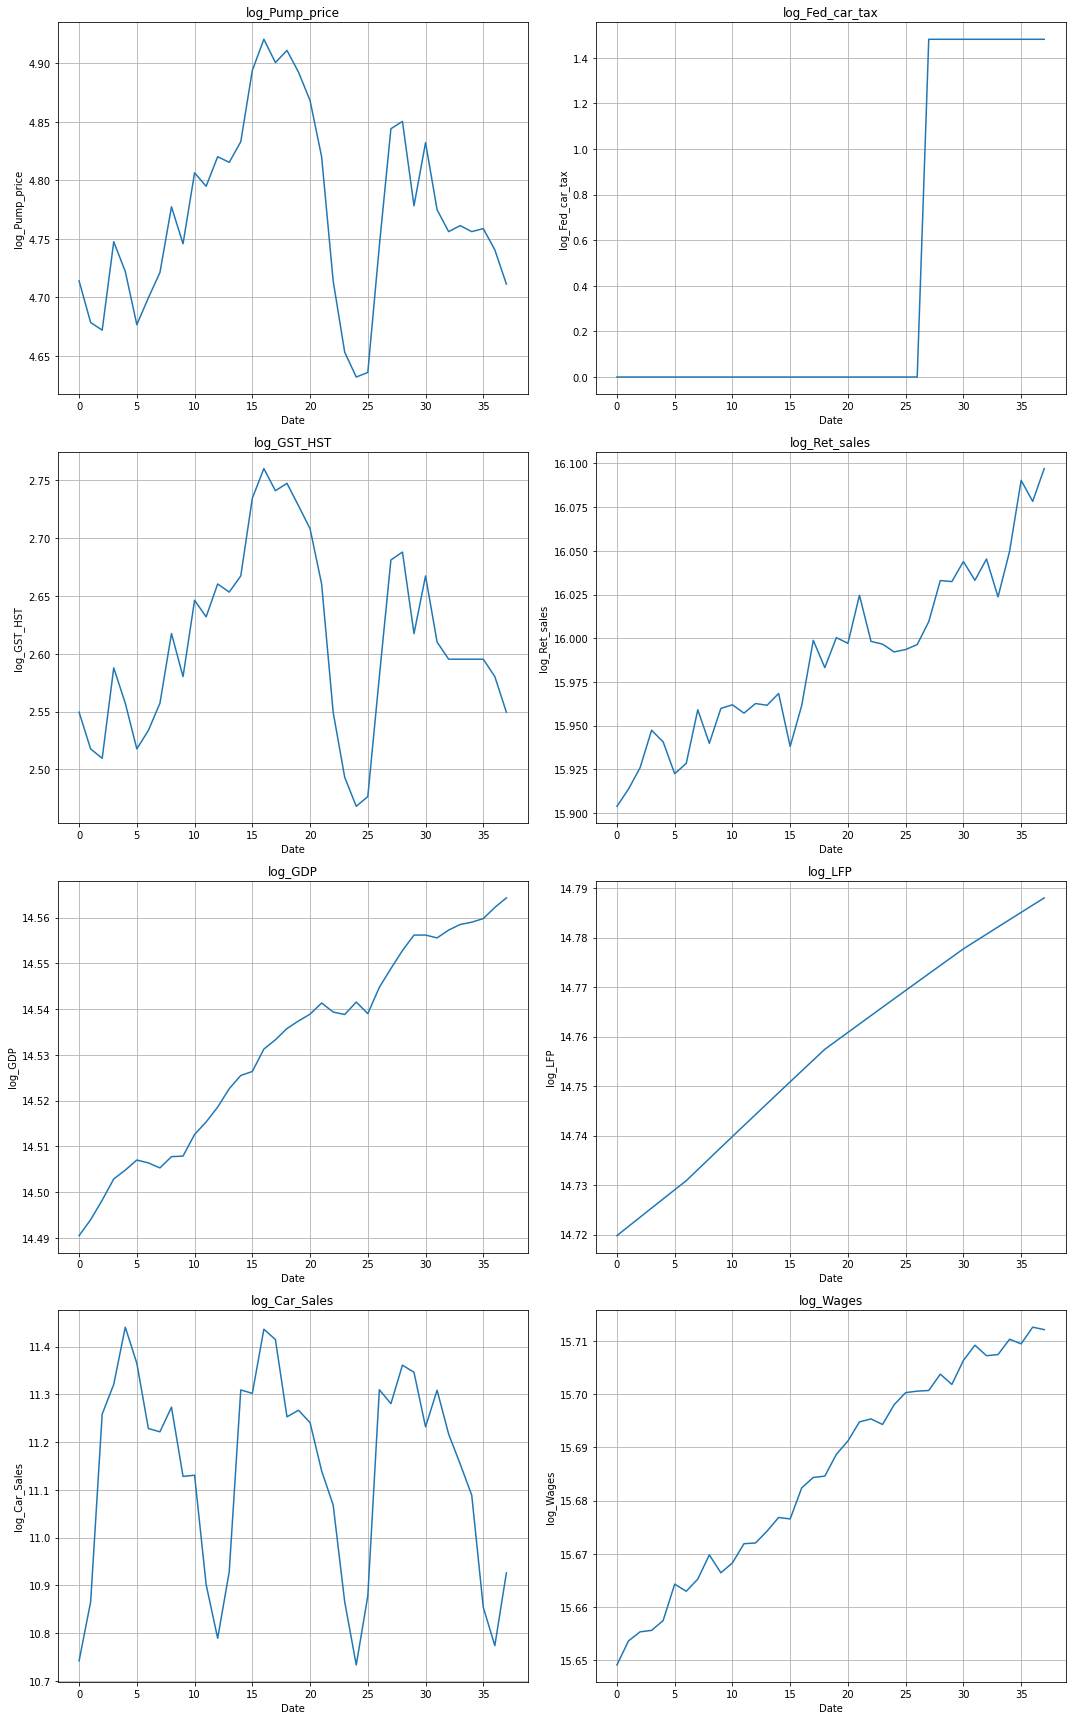

In [14]:
import os

# Save the plot to a location
save_path = "C:/Users/Sheva/Desktop/Images/"

# Determine the number of rows and columns for subplots
num_cols = len(log_df.columns[1:])
num_rows = num_cols // 2 + num_cols % 2  # Calculate the number of rows needed

# Create a new figure to contain all plots
plt.figure(figsize=(15, num_rows * 6))  # Adjust figure size as needed

# Plot each series separately
for i, column in enumerate(log_df.columns[1:], 1):  # Exclude the 'Date' column
    plt.subplot(num_rows, 2, i)
    plt.plot(log_df.index, log_df[column])
    plt.title(column)
    plt.xlabel('Date')
    plt.ylabel(column)
    plt.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Save the plot to the specified location as one image
plt.savefig(os.path.join(save_path, "all_plots.png"), bbox_inches='tight')

# Show the plot
plt.show()

In [16]:
import os
from statsmodels.tsa.stattools import adfuller

# Specify the location to save the text file
save_path = "C:/Users/Sheva/Desktop/"

# Create/Open the text file for writing
with open(os.path.join(save_path, "stationarity_results.txt"), "w") as file:
    # Check stationarity for each series
    for column in log_df.columns[1:]:
        series = log_df[column]

        # Method 1: ADF Test
        result = adfuller(series)
        file.write(f'ADF Statistic for {column}: {result[0]}\n')
        file.write(f'p-value: {result[1]}\n')
        file.write('Critical Values:\n')
        for key, value in result[4].items():
            file.write(f'\t{key}: {value}\n')

# Inform user about the completion
print("Stationarity results have been saved to 'stationarity_results.txt' file in the specified location.")


Stationarity results have been saved to 'stationarity_results.txt' file in the specified location.


In [18]:
import os
from statsmodels.tsa.stattools import adfuller

# Specify the location to save the text file
save_path = "C:/Users/Sheva/Desktop/"

# Create/Open the text file for writing
with open(os.path.join(save_path, "stationarity_results_after_differencing.txt"), "w") as file:
    # Apply differencing to non-stationary variables
    differenced_df = log_df.copy()

    # Take first difference of all variables except log_LFP
    differenced_df[differenced_df.columns[1:]] = differenced_df[differenced_df.columns[1:]].diff()

    # Take second difference of log_LFP
    differenced_df['log_LFP'] = log_df['log_LFP'].diff().diff()
    differenced_df['log_Wages'] = log_df['log_Wages'].diff().diff()

    # Drop NaN values resulting from differencing
    differenced_df = differenced_df.dropna()

    # Perform ADF test again and save results to the text file
    for column in differenced_df.columns[1:]:
        result = adfuller(differenced_df[column])
        file.write(f'ADF test results for {column}:\n')
        file.write('ADF Statistic: {}\n'.format(result[0]))
        file.write('p-value: {}\n'.format(result[1]))
        file.write('Critical Values:\n')
        for key, value in result[4].items():
            file.write(f'   {key}: {value}\n')
        if result[1] < 0.05:
            file.write(f'{column} is likely stationary\n\n')
        else:
            file.write(f'{column} is likely non-stationary\n\n')

# Inform user about the completion
print("Stationarity results after differencing have been saved to 'stationarity_results_after_differencing.txt' file in the specified location.")


Stationarity results after differencing have been saved to 'stationarity_results_after_differencing.txt' file in the specified location.


In [19]:
differenced_df.head()

,Date,log_Pump_price,log_Fed_car_tax,log_GST_HST,log_Ret_sales,log_GDP,log_LFP,log_Car_Sales,log_Wages
2,2017-03-01,-0.006527,0.0,-0.008097,0.012173,0.004268,-0.000003,0.393041,-0.002806
3,2017-04-01,0.075644,0.0,0.078165,0.021482,0.004636,-0.000003,0.062190,-0.001422
4,2017-05-01,-0.025473,0.0,-0.030537,-0.006669,0.001937,-0.000003,0.119711,0.001565
5,2017-06-01,-0.045504,0.0,-0.039531,-0.018161,0.002198,-0.000004,-0.075725,0.004998
6,2017-07-01,0.023011,0.0,0.016000,0.005845,-0.000629,-0.000003,-0.136494,-0.008183


In [20]:
#Create an ARDL model
# Specify lag order
lag_order = 1

# Define lagged variables, excluding the "Date" column
X_lagged = differenced_df.drop(columns=['log_Ret_sales', 'log_Fed_car_tax', 'Date']).shift(lag_order).dropna()
y_lagged = differenced_df['log_Ret_sales'].shift(lag_order).dropna()

# Fit AutoReg model
model = AutoReg(y_lagged, lags=lag_order, exog=X_lagged)
result = model.fit()

# Save model summary to a text file
with open("C:/Users/Sheva/Desktop/model_summary.txt", "w") as f:
    f.write(result.summary().as_text())

# Print model summary
print(result.summary())

                            AutoReg Model Results                             
Dep. Variable:          log_Ret_sales   No. Observations:                   35
Model:                   AutoReg-X(1)   Log Likelihood                  91.568
Method:               Conditional MLE   S.D. of innovations              0.016
Date:                Sun, 07 Apr 2024   AIC                             -7.695
Time:                        13:53:10   BIC                             -7.291
Sample:                             1   HQIC                            -7.557
                                   35                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
intercept            0.0031      0.004      0.725      0.469      -0.005       0.011
log_Ret_sales.L1    -0.3578      0.162     -2.206      0.027      -0.676      -0.040
log_Pump_price       0.2458 

C:\Users\Sheva\anaconda3.1\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\Users\Sheva\anaconda3.1\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


In [21]:
from statsmodels.tsa.api import AutoReg
import pandas as pd

# Specify lag order
lag_order = 1

# Define lagged variables, excluding the "Date" column
X_lagged = differenced_df.drop(columns=['log_Ret_sales', 'Date']).shift(lag_order).dropna()
y_lagged = differenced_df['log_Ret_sales'].shift(lag_order).dropna()

# Fit AutoReg model
modeltax = AutoReg(y_lagged, lags=lag_order, exog=X_lagged)
resulttax = modeltax.fit()

# Save model summary to a text file
with open("C:/Users/Sheva/Desktop/model_summary2.txt", "w") as f:
    f.write(resulttax.summary().as_text())

# Print model summary
print(resulttax.summary())



                            AutoReg Model Results                             
Dep. Variable:          log_Ret_sales   No. Observations:                   35
Model:                   AutoReg-X(1)   Log Likelihood                  91.570
Method:               Conditional MLE   S.D. of innovations              0.016
Date:                Sun, 07 Apr 2024   AIC                             -7.636
Time:                        13:53:14   BIC                             -7.187
Sample:                             1   HQIC                            -7.483
                                   35                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
intercept            0.0031      0.004      0.722      0.471      -0.005       0.011
log_Ret_sales.L1    -0.3576      0.162     -2.204      0.028      -0.676      -0.040
log_Pump_price       0.2450 

C:\Users\Sheva\anaconda3.1\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\Users\Sheva\anaconda3.1\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


In [22]:
# Specify the order for the ARIMA model
order = (1, 0, 1)  # You need to specify the appropriate order for your ARIMA model

# Fit ARIMA model
model_arima = ARIMA(differenced_df['log_Ret_sales'], order=order, exog=differenced_df.drop(columns=['Date', 'log_Fed_car_tax']))

# Fit the model
result_arima = model_arima.fit()

# Print model summary
print(result_arima.summary())

                               SARIMAX Results                                
Dep. Variable:          log_Ret_sales   No. Observations:                   36
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 381.372
Date:                Sun, 07 Apr 2024   AIC                           -740.745
Time:                        13:53:17   BIC                           -723.326
Sample:                             0   HQIC                          -734.665
                                 - 36                                         
Covariance Type:                  opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -1.626e-18        nan        nan        nan         nan         nan
log_Pump_price  4.441e-16         -0       -inf      0.000    4.44e-16    4.44e-16
log_GST_HST    -2.776e-16   2.84e-27

C:\Users\Sheva\anaconda3.1\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\Users\Sheva\anaconda3.1\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\Users\Sheva\anaconda3.1\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\Users\Sheva\anaconda3.1\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Sheva\anaconda3.1\lib\site-packages\statsmodels

In [23]:
# Specify the order for the ARIMA model
order = (1, 0, 1)  # You need to specify the appropriate order for your ARIMA model

# Fit ARIMA model
model_arima = ARIMA(differenced_df['log_Ret_sales'], order=order, exog=differenced_df.drop(columns=['Date']))

# Fit the model
result_arima = model_arima.fit()

# Print model summary
print(result_arima.summary())

                               SARIMAX Results                                
Dep. Variable:          log_Ret_sales   No. Observations:                   36
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 398.288
Date:                Sun, 07 Apr 2024   AIC                           -772.575
Time:                        13:53:21   BIC                           -753.573
Sample:                             0   HQIC                          -765.943
                                 - 36                                         
Covariance Type:                  opg                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const           -5.132e-06   9.75e-06     -0.526      0.599   -2.42e-05     1.4e-05
log_Pump_price  -2.691e-08      0.000     -0.000      1.000      -0.000       0.000
log_Fed_car_tax -8.325e-07   2.8

C:\Users\Sheva\anaconda3.1\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\Users\Sheva\anaconda3.1\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\Users\Sheva\anaconda3.1\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


In [24]:
differenced_df.head()

,Date,log_Pump_price,log_Fed_car_tax,log_GST_HST,log_Ret_sales,log_GDP,log_LFP,log_Car_Sales,log_Wages
2,2017-03-01,-0.006527,0.0,-0.008097,0.012173,0.004268,-0.000003,0.393041,-0.002806
3,2017-04-01,0.075644,0.0,0.078165,0.021482,0.004636,-0.000003,0.062190,-0.001422
4,2017-05-01,-0.025473,0.0,-0.030537,-0.006669,0.001937,-0.000003,0.119711,0.001565
5,2017-06-01,-0.045504,0.0,-0.039531,-0.018161,0.002198,-0.000004,-0.075725,0.004998
6,2017-07-01,0.023011,0.0,0.016000,0.005845,-0.000629,-0.000003,-0.136494,-0.008183


In [25]:
# Fit the ARIMA model using data before 2019-03-01
model = ARIMA(data_before_2019_03_01[target_variable], order=(1, 0, 1))
model_fit = model.fit()

# Make predictions for the trend before and after 2019-03-01
predictions_before = model_fit.predict(start=data_before_2019_03_01.index.min(), end=data_before_2019_03_01.index.max())
predictions_after = model_fit.forecast(steps=len(data_after_2019_03_01))

# Combine the predicted values with the actual data after 2019-03-01
combined_predictions = pd.concat([predictions_before, pd.Series(predictions_after)], axis=0)
combined_predictions.index = data_before_2019_03_01.index.append(data_after_2019_03_01.index)

# Set the date range for plotting
start_date = pd.to_datetime('2017-01-01')
end_date = pd.to_datetime('2020-04-01')

# Plot the actual and predicted values for the relevant time frame
plt.plot(differenced_df['Date'], differenced_df['log_Ret_sales'], label='Actual')
plt.plot(combined_predictions.index, combined_predictions, label='Predicted', linestyle='--')
plt.axvline(x=pd.to_datetime('2019-03-01'), color='r', linestyle='--', linewidth=1.5, label='2019-03-01')
plt.xlabel('Date')
plt.ylabel('log_Ret_sales')
plt.title('ARIMA Prediction Comparison before and after 2019-03-01')
plt.legend()
plt.xticks(rotation=45)
plt.xlim(start_date, end_date)  # Limit x-axis to the specified date range
plt.show()

NameError: name 'data_before_2019_03_01' is not defined

C:\Users\Sheva\anaconda3.1\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\Users\Sheva\anaconda3.1\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\Users\Sheva\anaconda3.1\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\Users\Sheva\anaconda3.1\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


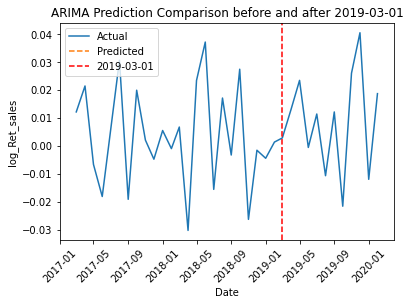

In [26]:
# Filter the data before and after 2019-03-01
data_before_2019_03_01 = differenced_df[differenced_df['Date'] < '2019-03-01']
data_after_2019_03_01 = differenced_df[differenced_df['Date'] >= '2019-03-01']

# Fit the ARIMA model using data before 2019-03-01
model = ARIMA(data_before_2019_03_01['log_Ret_sales'], order=(1, 0, 1))
model_fit = model.fit()

# Make predictions for the trend after 2019-03-01
predictions_after = model_fit.forecast(steps=len(data_after_2019_03_01))

# Combine the predicted values with the actual data after 2019-03-01
combined_predictions = pd.Series(predictions_after, index=data_after_2019_03_01.index)

# Set the date range for plotting
start_date = pd.to_datetime('2017-01-01')
end_date = pd.to_datetime('2020-04-01')

# Plot the actual and predicted values for the relevant time frame
plt.plot(differenced_df['Date'], differenced_df['log_Ret_sales'], label='Actual')
plt.plot(combined_predictions.index, combined_predictions, label='Predicted', linestyle='--')
plt.axvline(x=pd.to_datetime('2019-03-01'), color='r', linestyle='--', linewidth=1.5, label='2019-03-01')
plt.xlabel('Date')
plt.ylabel('log_Ret_sales')
plt.title('ARIMA Prediction Comparison before and after 2019-03-01')
plt.legend()
plt.xticks(rotation=45)
plt.xlim(start_date, end_date)  # Limit x-axis to the specified date range
plt.show()
